<a href="https://colab.research.google.com/github/JH-lee95/Projects/blob/master/Sentiment_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install nltk
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.5MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
     |████████████████████████████████| 3.6MB 40.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
#구글드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/'

'My Drive'


In [0]:
import nltk
import konlpy

In [0]:
nltk.download

konlpy.__version__

'0.5.2'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from konlpy.tag import Okt
import urllib.request
%matplotlib inline
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fca70f82048>)

In [0]:
train=pd.read_table("ratings_train.txt")
test=pd.read_table("ratings_test.txt")



# 1.EDA



In [0]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [0]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [0]:
train['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [0]:
test['label'].value_counts()

1    25173
0    24827
Name: label, dtype: int64

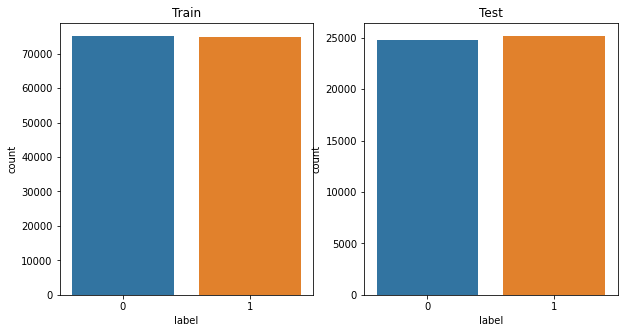

In [0]:
f,ax=plt.subplots(1,2,figsize=[10,5])

sns.countplot('label',data=train,ax=ax[0])
ax[0].set_title("Train")

sns.countplot('label',data=test,ax=ax[1])
ax[1].set_title("Test")
plt.show()

In [0]:
train['document'].isnull().sum()

5

In [0]:
#null 값이 있는 곳의 위치 확인
train.loc[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [0]:
train=train.dropna(axis=0)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [0]:
uniq=np.unique(train['document'])

In [0]:
len(uniq)

146182

In [0]:
#중복 데이터 제거

train.drop_duplicates(subset=['document'],inplace=True)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [0]:
train['label'].value_counts()

0    73342
1    72840
Name: label, dtype: int64

# 2. 데이터 전처리

In [0]:
# #정규표현식을 이용한 특수문자 등 제거

# train['document']=train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [0]:
#공백 처리된 데이터 NaN 값으로 변경

train['document'].replace("",np.nan,inplace=True)

In [0]:
train.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [0]:
train.loc[train.document.isnull()][:10]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2327,9317820,NaN,1
2648,423224,NaN,1
2834,3645129,NaN,0


In [0]:
train=train.dropna(axis=0)
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [0]:
len(train)

In [0]:
test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
# test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 49157


2-1 토큰화

In [0]:
#stopwords 정의, 경우에 따라 추가 가능!
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [0]:
okt=Okt()

In [0]:
# #트레인 데이터 토큰화
# X_train=[]
# for sentence in train['document']:
#   temp_X=[]
#   temp_X=okt.morphs(sentence,stem=True)
#   temp_X=[word for word in temp_X if word not in stopwords]
#   X_train.append(temp_X)


# #시간 절약을 위한 토큰화된 데이터 드라이브 저장
# with open('/content/drive/My Drive/xtrain_re.txt','wb') as f:
#   pickle.dump(X_train,f)

In [0]:
#시간 절약을 위한 데이터 로딩

with open('/content/drive/My Drive/xtrain_re.txt','rb') as file:
  X_train=[]
  while True:
    try:
      data=pickle.load(file)
    except EOFError:
      break
    X_train=data


In [0]:
X_train[:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [0]:
#테스트 테이터 토큰화

X_test = []
for sentence in test['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

with open('/content/drive/My Drive/xtest_re.txt','wb') as f:
  pickle.dump(X_test,f)

In [0]:
with open('/content/drive/My Drive/xtest_re.txt','rb') as file:
  X_test=[]
  data=pickle.load(file)
  X_test=data


2-2 정수인코딩


In [0]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [0]:
#단어의 등장 빈도수가 많을 수록 낮은 인덱스를 부여받는다.

tokenizer.word_index
len(tokenizer.word_index)

43752

In [0]:
#빈도수가 3회 미만으로 낮은 단어 확인
#빈도수가 너무 낮은 단어를 피팅에서 제외하기 위함

threshold = 3 #기준
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0


for k,v in tokenizer.word_counts.items():
  total_freq=total_freq+v

  if(v<threshold):
    rare_cnt+=1
    rare_freq+=v


print('단어 집합의 크기: ',total_cnt)
print('등장 빈도가 3회 미만인 단어의 수: ',rare_cnt )
print('단어 집합에서 희귀 단어의 비율: ',(rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ',(rare_freq/total_freq)*100)


단어 집합의 크기:  43752
등장 빈도가 3회 미만인 단어의 수:  24337
단어 집합에서 희귀 단어의 비율:  55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  1.8715872104872904


In [0]:
#전체 단어 개수에서 등장 빈도수가 3회 미만인 단어들을 제거하여 단어 집합 크기 제한
#0번 패딩을 고려한 +1

vocab_size=total_cnt-rare_cnt+1
print("단어 집합의 크기: ",vocab_size)

단어 집합의 크기:  19416


In [0]:
#각 리뷰에 포함된 단어의 인덱스가 vocab_size를 넘어갈 경우 인코딩에서 제외
#즉 인덱스 번호가 19416 이상일 경우, 중요하지 않다고 판단하여 제외

tokenizer=Tokenizer(vocab_size)  #가장 빈도가 높은 vocab_size(19416)만큼 사용
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

print(X_train[:5])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9], [6492, 105, 8118, 218, 56, 4, 26, 3603], [1023, 29, 9145, 24, 833, 1, 2579, 21, 1108, 240, 14243, 1076, 254, 240]]


In [0]:
y_train=np.array(train['label'])
y_test=np.array(test['label'])

In [0]:
#빈 샘플 제거 
#즉 위에서 피팅을 진행하며 빈도수가 2회 이하인 단어를 삭제했으므로, 
#그 단어들 만으로 구성된 문장들은 빈 샘플이 됐고, 그러한 빈 샘플들을 제거

drop_train=[index for index,sentence in enumerate(X_train) if len(sentence)<1]
drop_test=[index for index,sentence in enumerate(X_test) if len(sentence)<1]

In [0]:
#제거

X_train=np.delete(X_train,drop_train,axis=0)
y_train=np.delete(y_train,drop_train,axis=0)

print(len(X_train))
print(len(y_train))

145162
145162


In [0]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

48747
48747


2-3 패딩



리뷰의 최대 길이:  69
리뷰의 평균 길이:  10.812485361182679


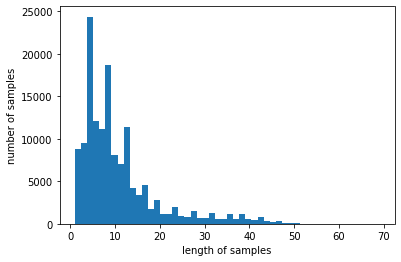

In [0]:
print('리뷰의 최대 길이: ',max(len(l) for l in X_train))
print('리뷰의 평균 길이: ',sum(map(len,X_train))/len(X_train)) #map(a,b) : iterable b에 대하여 a 함수 적용  
plt.hist([len(s) for s in X_train],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
def below_threshold_len(max_len,nested_list):
  cnt=0
  for s in nested_list:
    if(len(s)<=max_len):
      cnt=cnt+1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len,(cnt/len(nested_list))*100))

In [0]:
max_len=30
below_threshold_len(max_len,X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [0]:
#94 이상의 샘플들이 길이기 30 이하이므로 30의 길이로 패딩

X_train=pad_sequences(X_train,maxlen=max_len)
X_test=pad_sequences(X_test,maxlen=max_len)

In [0]:
X_train[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    50,   454,
           16,   260,   659],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   933,   457,    41,   602,     1,   214,  1449,    24,
          961,   675,    19],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   386,  2444,  2315,  5671,
            2,   222,     9],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  6492,   105,  8118,   218,    56,
            4,    26,  3603],
       [    0,     0,     0,

# 3. LSTM을 이용한 딥러닝 신경망 구축

In [0]:
#모듈 로딩

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #과적합 방지를 위한 EarlyStopping

In [0]:
#신경망 구성

model=Sequential()
model.add(Embedding(vocab_size,100))  #단어임베딩, 샘플 크기 = 사용할 단어 개수, 차원 = 100
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))

In [0]:
#더이상 loss가 감소하지 않는다면 학습종료

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)


#모델 성능(정확도)가 가장 좋을 경우만 저장
mc=ModelCheckpoint('best_model_re.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)



In [0]:
with open('/content/drive/My Drive/best_model_re.h5','wb') as f:
  pickle.dump('best_model_re.h5',f)

In [0]:
#모델 컴파일 및 학습

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(X_train,y_train,epochs=15,callbacks=[es,mc],batch_size=60,validation_split=0.2)


Epoch 1/15
1935/1936 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8264
Epoch 00001: val_acc improved from -inf to 0.84896, saving model to best_model_re.h5
1936/1936 [==============================] - 53s 28ms/step - loss: 0.3855 - acc: 0.8264 - val_loss: 0.3480 - val_acc: 0.8490
Epoch 2/15
1934/1936 [============================>.] - ETA: 0s - loss: 0.2961 - acc: 0.8733
Epoch 00002: val_acc improved from 0.84896 to 0.85231, saving model to best_model_re.h5
1936/1936 [==============================] - 53s 27ms/step - loss: 0.2961 - acc: 0.8733 - val_loss: 0.3474 - val_acc: 0.8523
Epoch 3/15
1935/1936 [============================>.] - ETA: 0s - loss: 0.2466 - acc: 0.8966
Epoch 00003: val_acc did not improve from 0.85231
1936/1936 [==============================] - 54s 28ms/step - loss: 0.2466 - acc: 0.8966 - val_loss: 0.3559 - val_acc: 0.8510
Epoch 4/15
1935/1936 [============================>.] - ETA: 0s - loss: 0.2038 - acc: 0.9161
Epoch 00004: val_acc did not i

In [0]:
with open('/content/drive/My Drive/best_model_re.h5','rb') as file:
  while True:
    try:
      loaded_model=pickle.load(file)
    except EOFError:
      break

In [0]:
#테스트 
loaded=load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test,y_test)[1]))

OSError: ignored

In [0]:
model.evaluate(X_test,y_test)

1524/1524 [==============================] - 8s 5ms/step - loss: 0.5243 - acc: 0.8357


[0.524309515953064, 0.8356617093086243]

In [0]:
#새로운 데이터 입력을 위한 전처리 과정 통합

def preprocessing(sentences):
  sent_list=[]
  for sentence in sentences:
    temp=[]
    sentence=" ".join(sentence)
    # sentence=sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    temp=okt.morphs(sentence,stem=True)
    temp=[word for word in temp if word not in stopwords]
    sent_list.append(temp)

  tokenizer.fit_on_texts(sent_list)
  sent_list=tokenizer.texts_to_sequences(sent_list)
  sent_list=pad_sequences(sent_list,maxlen=max_len)

  return sent_list

In [0]:
sentences=[['올해 최고의 영화입니다!'],['재밌어요'],['재미없어요'],['너무 재밌었어요!'],['연기를 너무 못함']]



In [0]:
a=preprocessing(sentences)
b=model.predict(a)
for i in b:
  print(i)

  if i[0]>=0.5:
    print('이 리뷰는 긍정리뷰입니다')

  else:
    print('이 리뷰는 부정리뷰입니다')

[0.9987318]
이 리뷰는 긍정리뷰입니다
[0.9756807]
이 리뷰는 긍정리뷰입니다
[0.00465481]
이 리뷰는 부정리뷰입니다
[0.99949634]
이 리뷰는 긍정리뷰입니다
[0.02519948]
이 리뷰는 부정리뷰입니다


In [0]:
def sentiment(sentences):
  a=preprocessing(sentences)
  b=model.predict(a)


  num_of_posi=0   #긍정 트윗 개수
  num_of_nega=0   #부정 트윗 개수
  

  for sent,pred in zip(sentences,b):
    if pred[0]>=0.5:
      print(sent[0])
      print("Positive. \n")
      num_of_posi +=1
    else:
      print(sent[0])
      print("Negative.\n")
      num_of_nega+=1

  print("전체 트윗중 부정 트윗의 비율(\'%\') : ",num_of_nega/(num_of_posi+num_of_nega)*100)
  print("전체 트윗중 긍정 트윗의 비율(\'%\') : ",num_of_posi/(num_of_posi+num_of_nega)*100)

In [0]:
!pip install twitterscraper
!pip install tweepy

     |████████████████████████████████| 92kB 6.4MB/s 
  Created wheel for twitterscraper: filename=twitterscraper-1.4.0-cp36-none-any.whl size=11347 sha256=8651628704916811cc1cca52288ece99aeb205fb4904c49720fcffafc3aaba4a
  Stored in directory: /root/.cache/pip/wheels/c2/9c/8b/7393e7bdc8abe6ce0d46c2ffae2035a1a2080a97ff0ddbdde6
Successfully built twitterscraper


In [0]:
import twitterscraper
from twitterscraper import query_tweets

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'}


In [0]:
import tweepy


consumer_key = "PqICmArGSxkIHNtq4wbGykpkv"

consumer_secret = "ZRp5ilQvwOKj6jExUEIKQC5OoICGSbWUH0pok1xZ7ZvRoAWUyO"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)



# access 토큰 요청

access_token = "1244509487127379970-Oz4UMNX4N0ydH4OtYTqnolaxxgaDhC"

access_token_secret = "mqNXpnGbnh2CtmRH4j7BSLzssfcIQSahqoKuNNPqIjvAv"

auth.set_access_token(access_token, access_token_secret)



# twitter API 생성  

api = tweepy.API(auth)

In [0]:
def get_tweets(query, count = 1000): 

  
    tweets = [] 

    try: 
    
        fetched_tweets = api.search(q = query, count = count) 
        
        for tweet in fetched_tweets: 
            
            parsed_tweet = []
             
            parsed_tweet.append(tweet.text)
            
  

            if tweet.retweet_count > 0:   #리트윗은 한번만 기록

                if parsed_tweet not in tweets: 
                    tweets.append(parsed_tweet) 
            else: 
                tweets.append(parsed_tweet) 


        return tweets 


        print("Error : " + str(e))


In [0]:
tweets_list=get_tweets("영화 침입자")

In [0]:
#크롤링한 트윗 파일로 저장
with open('/content/drive/My Drive/tweets_list.txt','wb') as f:
  pickle.dump(tweets_list,f)

In [0]:
with open('/content/drive/My Drive/tweets_list.txt','rb') as file:
  tweets_list=pickle.load(file)

In [0]:
sentiment(tweets_list)

침입자 영화 괜찮은데 보는 내가 너무 괴로워.. 고난과 역경 과다
Negative.

RT @itayloryou: 겟아웃 + 어스 + 유전을 다 보고 싶은데 
시간없는 한국인은 영화 &lt;침입자&gt;를 보세요. https://t.co/g5IjePbKCH
Negative.

RT @itayloryou: 영화 &lt;침입자&gt; 스릴러보다는 추리소설 느낌인데
피곤하고 의욕없는 얼굴을 하고는
광기라는걸 뽑아내는 &lt;송지효 배우님&gt;의 연기가 
영화 전체의 긴장감을 끌고가면서 
묘하고 섬뜩한 호러를 만들어냄 https://t.co/hwP…
Negative.

영화 침입자보고 누가 유전이랑 미드소마 같다고 했는데 딱이다. 한국형 유전이네. 난 재밌게 봤음. 송지효가 아니면 누가 이거 해.
Positive. 

[침입자]최신영화 다시보기 고화질 다운로드 무료보기
https://t.co/77EBUlL5aZ
마루TV
마루TV주소
마루TV접속
마루TV같은사이트
한고새
한곳에
외국영화
한국영화
미드
시리즈
예능다시보기
최… https://t.co/F00QkG1QXL
Positive. 

[침입자]최신영화 다시보기 고화질 다운로드 무료보기
https://t.co/HjDHNFnbcb
링크모음
주소모아
다시보기
한곳에
한고세
무료다시보기
미드다시보기
예능다시보기
최신주소
무료영화
공포영화
멜로영… https://t.co/XK8m3rOA16
Positive. 

[무비포커스] ‘침입자’ ‘결백’ 그리고 ‘#살아있다’…한국 영화의 시간은 흐른다 #침입자 #영화침입자 #개봉영화 #영화결백 #결백 #살아있다 #영화살아있다 #영화다만악에서구하소서 #다만악에서구하소서 #반도… https://t.co/nHEI6wGcUD
Negative.

RT @Ilovedramamovie: 이번 달 영화관 가서 볼 영화

침입자- 지효언니 보러 가야함
결백- 혜선언니 보러 가야함
살아있다- 신혜언니 보러 가야함
Positive. 

침입자 보고왔는데
반전이고 반전일것같고 반전이다 반전이 아닌데 반

In [0]:
aaa=api.search("영화 침입자",count=10)